© [Mariia Seleznova](https://www.ai.math.uni-muenchen.de/members/phd_students/seleznova/index.html) 2022

https://github.com/mselezniova/MSML22

Distributed under the [Creative Commons Attribution License](https://creativecommons.org/licenses/by/4.0/)

# Lasso regression on Boston housing dataset

In [62]:
import os

import numpy as np
import pandas as pd

%pylab inline
%config InlineBackend.figure_format='svg'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Load the dataset:

In [63]:
file_name = 'boston_housing.csv'
url = 'https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv'

if os.path.exists(file_name):
    print(f'Loading data from local file `{file_name}`...')
    df = pd.read_csv(file_name, index_col=0)
else:
    print(f'Loading data from `{url}`...')
    df = pd.read_csv(url)
    df.to_csv(file_name)
    print('Done.')

Loading data from local file `boston_housing.csv`...


In [64]:
df

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


Split the data into train and test subsets and normalize:

In [65]:
def  train_test_split(df, training_data_fraction, shuffle=True):
    
    if shuffle is True:
        df_ = df.sample(frac=1).reset_index(drop=True)
    else:
        df_= df
    
    train_df = df_.iloc[:round(training_data_fraction*len(df_)),:]
    test_df = df_.iloc[round(training_data_fraction*len(df_)):,:]
    
    return df_, train_df, test_df

def normalize(x):
    return (x - np.mean(x, axis=0))/np.std(x,axis=0)

In [66]:
training_data_fraction = .8

df, train_df, test_df =  train_test_split(df, training_data_fraction)

X = normalize(df.iloc[:,df.columns != 'medv'].to_numpy())
Y = df.iloc[:,df.columns == 'medv'].to_numpy().reshape(-1)

train_X = normalize(train_df.iloc[:,df.columns != 'medv'].to_numpy())
train_Y = train_df.iloc[:,df.columns == 'medv'].to_numpy().reshape(-1)

test_X = normalize(test_df.iloc[:,df.columns != 'medv'].to_numpy())
test_Y = test_df.iloc[:,df.columns == 'medv'].to_numpy().reshape(-1)

Implement a linear regression model and a lasso regression model with GD training:

In [71]:
class LinearRegression:

    def __init__(self, w, b):
        self._w = np.array(w, dtype=float)
        self._b = np.array(b, dtype=float)
        self.history = [{'w': self._w.copy(),
                         'b': self._b.copy(),
                         'loss': None}]
        
    def h(self, x):
        return x @ self._w + self._b
    
    def loss(self, X, Y):
        ones_vec = np.ones(X.shape[0])
        return 0.5/X.shape[0]*np.dot(X@self._w + self._b*ones_vec - Y,
                          X@self._w + self._b*ones_vec - Y)
    
    def loss_grad(self, X,Y):
        ones_vec = np.ones(X.shape[0])
        return X.T@(X@self._w + self._b*ones_vec - Y)/X.shape[0], ones_vec.T@(X@self._w 
                                                                    + self._b*ones_vec - Y)/X.shape[0]    
    
    def train(self, X, Y, lr = 1e-3, num_iter = 100):
        
        self.history[0]['loss'] = self.loss(X,Y)
        
        for e in range(num_iter):
            
            grad_w, grad_b = self.loss_grad(X,Y)
            self._w -= lr*grad_w
            self._b -= lr*grad_b
            
            self.history.append({'w': self._w.copy(),
                                 'b': self._b.copy(),
                                 'loss': self.loss(X,Y)})
            
        return self._w, self._b
    
    
class LassoRegression(LinearRegression):
    
    def __init__(self, w, b, l):
        super().__init__(w,b)
        self.l = np.array(l, dtype=float)
        
        
    def MSE(self, X, Y):
        ones_vec = np.ones(X.shape[0])
        return 1./X.shape[0]*np.dot(X@self._w + self._b*ones_vec - Y,
                          X@self._w + self._b*ones_vec - Y)
    
    def loss(self, X, Y):
        ones_vec = np.ones(X.shape[0])
        return 0.5/X.shape[0]*np.dot(X@self._w + self._b*ones_vec - Y,
                          X@self._w + self._b*ones_vec - Y) + self.l*np.linalg.norm(self._w,ord=1)
    
    def loss_grad(self, X,Y):
        ones_vec = np.ones(X.shape[0])
        l1_grad = np.where(self._w>0,1,-1)
        return X.T@(X@self._w + self._b*ones_vec - Y)/X.shape[0] + self.l*l1_grad, ones_vec.T@(X@self._w 
                                                                    + self._b*ones_vec - Y)/X.shape[0]    

As in the exercise class, we can plot the performance of the lasso model and the norm of the coefficients as a function of the regularization parameter $\lambda$:

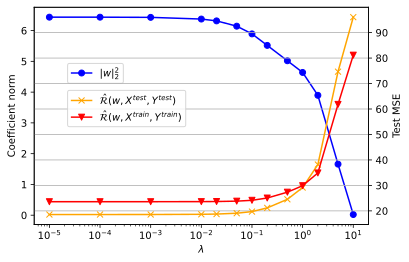

In [72]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

w = np.array([0]*X.shape[-1])
b = 0

ls = [1e-5,1e-4,1e-3,1e-2,2e-2,5e-2,1e-1,0.2,0.5,1.,2,5,10]
w_norms = []
test_losses = []
train_losses = []
w_s = []

for l in ls:

    model = LassoRegression(w, b, l=l)
    model.train(train_X,train_Y, lr = 1e-3, num_iter = 10000)
    
    w_norms.append(np.linalg.norm(model._w))
    test_losses.append(model.MSE(test_X,test_Y))
    train_losses.append(model.MSE(train_X,train_Y))
    w_s.append(model._w)
    

ax.plot(ls, w_norms, color = 'blue', marker='o', label = '$\|w\|^2_2$')   
ax2.plot(ls, test_losses, color = 'orange', marker='x', label = '$\hat{\mathcal{R}}(w,X^{test},Y^{test})$')   
ax2.plot(ls, train_losses, color = 'red', marker='v', label = '$\hat{\mathcal{R}}(w,X^{train},Y^{train})$')   
ax.set_xscale('log')
    
ax.set_xlabel('$\lambda$')
ax.set_ylabel('Coefficient norm')
ax2.set_ylabel('Test MSE')
plt.grid()
ax.legend(loc=(0.1,0.65))
ax2.legend(loc=(0.1,0.45))

We also plot how the individual coefficients, corresponding to each variable in the dataset, change depending on the strength of regularization. One can see that Lasso zeroes out more and more variables as we increase the regularization parameter. Therefore, Lasso can generate sparse solutions, which only depend on a small subset of initial variables:

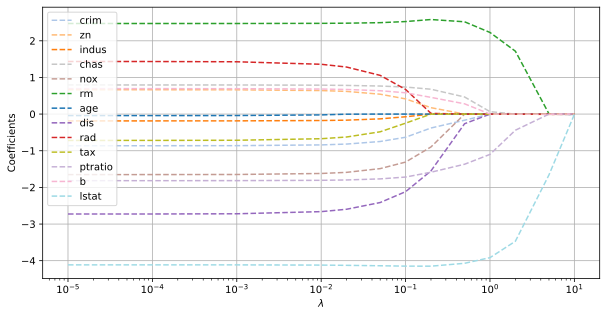

In [73]:
fig, ax = plt.subplots(figsize = (10,5))

w_s = np.array(w_s)

cmap = np.random.permutation(matplotlib.cm.get_cmap('tab20').colors)

for i in range(X.shape[1]):
    plt.plot(ls, w_s[:,i],ls='--', label=df.columns[i], color=cmap[i])
    
    
zeroed_fet = []
eps = 1e-1

for i in range(len(ls)):
    zeroed_fet.append(np.argwhere(np.abs(w_s[i,:])<eps))

plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Coefficients')
plt.grid()
plt.legend()

In our case, the last 5 variables that are not zeroed with increasing regularization are: 
- LSTAT - % lower status of the population
- RM - average number of rooms per dwelling
- PTRATIO - pupil-teacher ratio by town
- B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)

These variables are likely to be the best predictors of the house pricing, since leaving only them "active" does not significantly reduce the model performance. Let us also look at the coefficients assigned to these features by a model with $\lambda=0.5$.

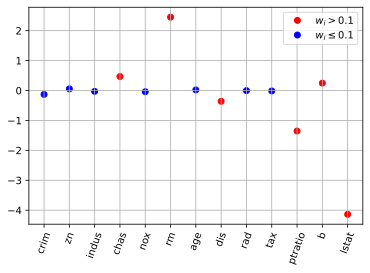

In [75]:
model = LassoRegression(w, b, l=0.5)
model.train(train_X,train_Y, lr = 1e-1, num_iter = 100000)

fig, ax = plt.subplots()

colors = np.where(np.abs(model._w)>2e-1,'red', 'blue')

ax.scatter(np.arange(len(model._w)), model._w, color=colors)
ax.set_xticks(np.arange(len(model._w)))
ax.set_xticklabels(df.columns[:-1], rotation=70)

ax.plot([],[], linestyle='', marker='o', color='red', label='$w_i>0.1$')
ax.plot([],[], linestyle='', marker='o', color='blue', label='$w_i\leq 0.1$')

ax.grid()
ax.legend()